# Minesweeper Version 2

## Library


In [11]:
import asyncio
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
import IPython.display as display
from IPython.display import clear_output
from numpy.random import default_rng
import sys
from pprint import pprint
from warnings import warn
import time



## Define Minesweeper


In [12]:
def newMinefield(size = np.array([15, 10]), mines = 16):
    field: object = np.zeros(size[0]*size[1])
    rng: object = default_rng()
    numbers: object = rng.choice(np.product(size), size=mines, replace=False)
    minefield: object = np.zeros(size+2) + float("inf")
    prob: object = np.array(minefield)

    field[numbers] = -9
    field = field.reshape(size)
    minefield[1:-1, 1:-1] = field
    positions: object = np.array(np.where(minefield==-9))
    for x, y in zip(*positions):
        grid: object = minefield[x-1:x+2, y-1:y+2]
        grid[grid != -9] -= 1
    minefield[minefield == 0] = -float("inf")
    prob[1:-1, 1:-1] = np.ones_like(field) * mines/np.product(size)
    return minefield, prob

## Basic Functions


In [13]:
def pick(field, locations):
    x,y = locations
    if abs(field[x,y]) != float("inf"):
        field[x,y] = abs(field[x,y])
        return field[x, y]
    elif field[x, y] == -float("inf"):
        field[x, y] = 0
        for i in range(-1, 2):
            for j in range(-1, 2):                
                pick(field, (x+i, y+j))
        return 0
    clear_output(wait=True)
    print(txt2pic(field[1:-1, 1:-1]))

def txt2pic(A):
    shape = np.shape(A)
    s = ""
    B = np.array([["\x1b[30m\x1b[48;5;208m9\x1b[0m"]*shape[1]]*shape[0])
    B[:,:] = "\x1b[30m\x1b[40m0\x1b[0m"
    
    B[probability[1:-1, 1:-1] == 1] = "\x1b[44m\x1b[38;5;9mF\x1b[0m"
    B[A == 0] = "\x1b[37m\x1b[47m0\x1b[0m"
    B[A == 1] = "\x1b[30m\x1b[46m1\x1b[0m"
    B[A == 2] = "\x1b[30m\x1b[42m2\x1b[0m"
    B[A == 3] = "\x1b[30m\x1b[43m3\x1b[0m"
    B[A == 4] = "\x1b[30m\x1b[44m4\x1b[0m"
    B[A == 5] = "\x1b[30m\x1b[41m5\x1b[0m"
    B[A == 6] = "\x1b[30m\x1b[106m6\x1b[0m"
    B[A == 7] = "\x1b[30m\x1b[45m7\x1b[0m"
    B[A == 8] = "\x1b[30m\x1b[104m8\x1b[0m"
    B[A == 9] = "\x1b[30m\x1b[48;5;208m9\x1b[0m"
    for r in B:
        for c in r:
            s += c
        s += "\n"
    return s

def quickPick(field):
    inf = float('inf')
    index = np.shape(field)
    point = np.array([0, 0])
    if np.size(field) == 1:
        return point
    if np.count_nonzero(field != -inf) == 0:
        return np.floor_divide(index, 2)
    if index[0] > index[1]:
        _arr1 = field[0:-1, :]
        _arr2 = field[1:, :]
    else:
        _arr1 = field[:, 0:-1]
        _arr2 = field[:, 1:]
    if np.count_nonzero(_arr2 == -inf) > np.count_nonzero(_arr1 == -inf):
        if index[0] > index[1]:
            point[0] += 1
        else:
            point[1] += 1
        point += quickPick(_arr2)
    else:
        point += quickPick(_arr1)
    return point

## Solving The Board


In [14]:
async def solver1(field, prob, mines):
    def check():
        while not quick(field, prob):
            pass
        return "SOLVED"
    
    def quick(_field, _prob):
        _prob[np.logical_and(_field < -9, _field >= 0)] = 0
        if np.count_nonzero(_field < 0) == mines - np.count_nonzero(prob == 1):
            return True
        if mines - np.count_nonzero(_field == 9) == 0:
            selection = np.where(_field<0)
            for coords in zip(*selection):
                pick(_field, coords)
                return True
        return False
    
    def shadowsEdge(_field, _prob):
        shape: tuple = np.shape(_field)
        selectioners: list = []
        _prob[np.logical_and(_field >= 0, _field <= 9)] = 0

        for x in range(1, shape[0] - 1):
            for y in range(1, shape[1] - 1):
                grid = _field[x - 1 : x + 2, y - 1 : y + 2]
                if (
                    0 < _prob[x, y] < 1
                    and np.count_nonzero(np.logical_and(grid >= 0, grid <= 9)) > 0
                ):
                    selectioners.append(np.array([x, y]))

        return selectioners

    def lightsEdge(_field, _prob):
        _prob[np.logical_and(_field >= 0, _field <= 9)] = 0
        shape: tuple = np.shape(_prob)
        interest: list = []
        for x in range(1, shape[0]-1):
            for y in range(1, shape[1]-1):
                grid = _prob[x - 1 : x + 2, y - 1 : y + 2]
                if (
                    grid[1, 1] == 0
                    and np.count_nonzero(np.logical_and(grid < 1, grid > 0)) >= 1
                ):
                    interest.append(np.array([x, y]))
        return interest

    def split(_field, _prob):
        # Get points of interests
        darkEdge = shadowsEdge(_field, _prob)
        lightEdge = lightsEdge(_field, _prob)
        interest = darkEdge + lightEdge
        loops = []
        while len(interest) > 0:
            # Start a new chain. Go through the remaining points of interest.
            # If they are within one square, add them to the loop.

            # When the no more are available for the loop, mve nto the next loop
            loops.append([interest.pop(0)])
            loop = loops[-1]
            i = 0
            while i < len(loop):
                loo = loop[i]
                for j in range(len(interest)-1, -1, -1):
                    ints = interest[j]
                    diff = np.abs(loo - ints)
                    if diff[diff < 2].all():
                        loop.append(interest.pop(j))
                i += 1
        return loops

    async def unos(_field, _prob, mines):
        works = True
        while works:
            samples = lightsEdge(_field, _prob)
            works = False
            for x, y in samples:
                gridF = _field[x-1:x+2, y-1:y+2]
                gridP = _prob[x-1:x+2, y-1:y+2]
                _mines = np.count_nonzero(gridP == 1)
                _safe = np.count_nonzero(np.logical_or(gridP == 0, gridP == float("inf"))) 
                
                if _mines == gridF[1, 1] and _safe + _mines < 9:
                    taps = np.transpose(np.where(np.logical_and(gridP<1, gridP>0)))-1
                    for t in taps:
                        pick(_field, t+np.array([x,y]))
                    _prob[np.logical_and(_field>=0, _field<=9)] = 0
                    works = True
                    
                elif 9 - _safe == gridF[1, 1] and _mines != gridF[1, 1]:
                    gridP[np.logical_and(gridP > 0, gridP < 1)] = 1
                    clear_output(wait=True)
                    print(txt2pic(field[1:-1, 1:-1]))
                    works = True
        await majorBrute(_field, _prob, mines)

    async def majorBrute(_field, _prob, _mines):
        
        def _check(prob):
            if _mines < np.count_nonzero(prob == 1):
                return False
            if _mines > np.product(np.shape(_field[1:-1, 1:-1]))-np.count_nonzero(prob == 0):
                return False
            for x in range(1, shape[0]-1):
                for y in range(1, shape[1]-1):
                    if _field[x, y] > 0 and _field[x, y] != float("inf"):
                        grid = prob[x - 1 : x + 2, y - 1 : y + 2]
                        if np.count_nonzero(grid == 1) > _field[x, y]:
                            return False
                        if 9-np.count_nonzero(np.logical_or(grid == 0, grid == float("inf"))) < _field[x, y]:
                            return False
            return True
        
        def solveSection(_interests):
            investigate: list = [[], []]
            last: list = [[1], [_prob]]
            base: int = 0
            while True:
                for index, field in zip(last[0], last[1]):
                    if play == False:
                        return True
                    for i in range(2):
                        
                        tempMap = np.array(field)
                        tempMap[tuple(_interests[base])] = i

                        if _check(tempMap):
                            investigate[0].append((index << 1) + i)
                            investigate[1].append(tempMap)

                ands = reduce(lambda a, b: a & b, investigate[0])
                ors = reduce(lambda a, b: a | b, investigate[0])
                ands = bin(ands)[3:]
                ors = bin(ors)[3:]
                if ands.count("1") > 0:
                    for j, a in enumerate(ands):
                        if a == "1":
                            _prob[tuple(_interests[j])] = 1
                            clear_output(wait=True)
                            print(txt2pic(field[1:-1, 1:-1]))
                    return True

                elif ors.count("0") > 0:
                    for j, o in enumerate(ors):
                        if o == "0":
                            pick(_field, tuple(_interests[j]))
                    _prob[np.logical_and(minefield >= 0, minefield <= 9)] = 0
                    return True

                if base + 1 == len(_interests):
                    return (investigate[0], _interests)
            
                base += 1
                last = list(investigate)
                investigate = [[], []]

        print("Stage 2")
        _prob[np.logical_and(_field >= 0, _field <= 9)] = 0
        shape = np.shape(_field)
        loops = split(_field, _prob)
        darks = shadowsEdge(_field, _prob)
        interest = []
        for loop in loops:
            preInterest = np.array([x for x in set(tuple(x) for x in darks) & set(tuple(x) for x in loop)])
            interest.append(list(preInterest))
        play = True
        print(len(loops))
        pprint(loops)
        if len(loops) > 1:
            print("Multiples")
        threads = [asyncio.to_thread(solveSection, ints) for ints in interest]
        tasks = {asyncio.create_task(thread) for thread in threads}
        sections = asyncio.as_completed(tasks)
        results = []
        for section in sections:
            result = await section         
            if result == True:
                play = False
            else:
                results.append(result)
        if not play:
            return await unos(_field, _prob, _mines)
        else:
            return await final(_field, _prob, _mines, results)

    async def final(_field, _prob, mines, results):
        last = [""]
        new = []
        selection = []
        print(len(results))
        minesLeft = mines - np.count_nonzero(_prob == 1)
        for r in results:
            selection += r[1]
            for bins in r[0]:
                b = bin(bins)[3:]
                for las in last:
                    if (las+b).count("1") <= minesLeft:
                        new.append(las+b)
            last = list(new)
            new = []
        minMines = float("inf")
        
        for las in last:
            minMines = min(minMines, las.count("1"))

        if minMines == minesLeft and np.count_nonzero(np.logical_and(prob > 0, prob < 1)) > len(selection):
            shadows = np.logical_and(prob<1, prob>0)
            for selec in selection:
                shadows[tuple(selec)] = False
            for point in np.transpose(np.where(shadows)):
                pick(_field, point)
            return await unos(_field, _prob, mines)
        
        lastInts = [int("1" + las, 2) for las in last]
        ands = reduce(lambda a, b: a & b, lastInts)
        ors = reduce(lambda a, b: a | b, lastInts)
        ands = bin(ands)[3:]
        ors = bin(ors)[3:]
        if ands.count("1") > 0 or ors.count("0") > 0:
            if ands.count("1") > 0:

                for j, a in enumerate(ands):
                    if a == "1":
                        _prob[tuple(selection[j])] = 1
                        clear_output(wait=True)
                        print(txt2pic(field[1:-1, 1:-1]))
            if ors.count("0") > 0:
                for j, o in enumerate(ors):
                    if o == "0":
                        pick(_field, tuple(selection[j]))
                _prob[np.logical_and(_field >= 0, _field <= 9)] = 0 
            return await unos(_field, _prob, mines)
                 
        averageNo = np.sum([las.count("1") for las in last])/len(last)
        
        chanceDarkness = (minesLeft - averageNo)/(np.count_nonzero(np.logical_and(_prob>0, _prob<1))-len(selection))
        _prob[np.logical_and(_prob > 0, _prob < 1)] = chanceDarkness
        
        group = np.array([[int(a) for a in c] for c in last])
        vertCount = np.count_nonzero(group, axis=1)
        chancePerSquare = vertCount / len(selection)
        for c, xy in zip(chancePerSquare, selection):
            _prob[tuple(xy)] = c
        lowestP = np.transpose(np.where(_prob == np.min(_prob[_prob > 0])))
        print(lowestP[0])
        nxt = pick(_field, tuple(lowestP[0]))
        if nxt == 9:
            print("GAME OVER")
            return "GAME OVER"
        return await unos(_field, _prob, mines)
    
    # c = asyncio.create_task(asyncio.to_thread(check))
    a = asyncio.create_task(unos(field, prob, mines))
    # finalResult = await c
    # print("KILL")
    # asyncio.Task.cancel(a)
    # print(f"FINAL RESULT: {finalResult}")
    return await a

In [15]:
def mainIndex(subarray, _array, index):
    x, y = index
    temp = subarray[x, y]
    frst = [x for x in zip(*np.where(_array == temp))]
    subarray[x, y] = temp - 1
    scnd = [x for x in zip(*np.where(_array == temp - 1))]
    subarray[x, y] = temp
    return list(set(frst) & set(scnd))[0]


X = np.reshape([i % 4 + 1000 for i in range(169)], [13, 13])
grid = X[2:8, 4:9]
mainIndex(grid, X, (1, 2))

(3, 6)

In [16]:
mines = 40
size = np.array([16, 30])
minefield, probability = newMinefield(size, mines)
pick(minefield, quickPick(minefield))

await solver1(minefield, probability, mines)
clear_output(wait=True)
print(txt2pic(minefield[1:-1, 1:-1]))


192111110001F10000000000000000
112F11F10001110011100001110000
00111111111000001F100001F11110
111000001F10000011100001111F10
1F2100001110000000000000001110
23F100011101110111000000000000
1F210002F201F101F1000111000000
11100113F2011101110001F2100000
000001F2110011211000024F200000
0111012210012F2F100112FF200000
01F1001F2101F2322012F222100000
01121113F201111F101F2211011100
0001F102F2000011101111F101F100
110111011211000000000112121211
F100000001F1001110000012F112F1
110000000111001F1000001F211F21



In [17]:
clear_output(wait=True)
print(txt2pic(minefield[1:-1, 1:-1]))

192111110001F10000000000000000
112F11F10001110011100001110000
00111111111000001F100001F11110
111000001F10000011100001111F10
1F2100001110000000000000001110
23F100011101110111000000000000
1F210002F201F101F1000111000000
11100113F2011101110001F2100000
000001F2110011211000024F200000
0111012210012F2F100112FF200000
01F1001F2101F2322012F222100000
01121113F201111F101F2211011100
0001F102F2000011101111F101F100
110111011211000000000112121211
F100000001F1001110000012F112F1
110000000111001F1000001F211F21



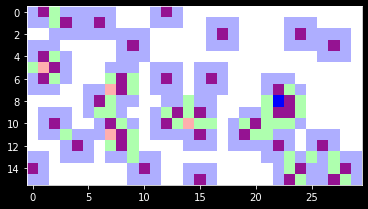

In [18]:
def present(field):
    shape = np.shape(field)
    img = np.zeros([*shape, 3])
    img[np.logical_or(field == 0, field == float("inf")), :] = [
        256, 256, 256]  # White
    img[field == 1, :] = [175, 175, 256]  # Light Blue
    img[field == 2, :] = [175, 256, 175]  # Light Green
    img[field == 3, :] = [256, 175, 175]  # Light Red
    img[field == 4, :] = [0, 0, 256]  # Blue
    img[field == 5, :] = [256, 0, 0]  # Red
    img[field == 6, :] = [0, 256, 0]  # Green
    img[field == 7, :] = [200, 60, 200]  # Purple
    img[field == 8, :] = [250, 150, 0]  # Orange
    img[field == 9, :] = [150, 0, 0]  # Brown
    img[field == 10, :] = [150, 20, 147]  # Dark Purple
    img = img / 256
    plt.imshow(img)

def imgArray(field):
    shape = np.shape(field)
    img = np.zeros([*shape, 3])
    img[np.logical_or(field == 0, field == float("inf")), :] = [
        256, 256, 256]  # White
    img[field == 1, :] = [175, 175, 256]  # Light Blue
    img[field == 2, :] = [175, 256, 175]  # Light Green
    img[field == 3, :] = [256, 175, 175]  # Light Red
    img[field == 4, :] = [0, 0, 256]  # Blue
    img[field == 5, :] = [256, 0, 0]  # Red
    img[field == 6, :] = [0, 256, 0]  # Green
    img[field == 7, :] = [200, 60, 200]  # Purple
    img[field == 8, :] = [250, 150, 0]  # Orange
    img[field == 9, :] = [150, 0, 0]  # Brown
    img[field == 10, :] = [150, 20, 147]  # Dark Purple
    img = img / 256
    
    return img

fieldImg = np.array(minefield)
fieldImg[probability == 1] = 10
present(fieldImg[1:-1,1:-1])

In [19]:
print("\x1b[30m\x1b[48;5;208m9\x1b[0m")

9


In [27]:
import numpy as np

A = np.reshape(np.arange(100), [10, 10])
A

B = A[3:6, 3:6]

B[1, 1] = 1
A

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43,  1, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])